In [1]:
import torch
import torchvision
import tqdm
import matplotlib.pyplot as plt

GPU

In [2]:
# 使用 GPU
def try_gpu(i=0):  #@save
    """如果存在，则返回gpu(i)，否则返回cpu()"""
    if torch.cuda.device_count() >= i + 1:
        return torch.device(f'cuda:{i}')
    return torch.device('cpu')

def try_all_gpus():  #@save
    """返回所有可用的GPU，如果没有GPU，则返回[cpu(),]"""
    devices = [torch.device(f'cuda:{i}')
             for i in range(torch.cuda.device_count())]
    return devices if devices else [torch.device('cpu')]

加载数据

In [3]:
# 数据预处理, 调整图片大小
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),torchvision.transforms.Resize([224, 224])])

# 下载Fashion-MNIST训练集数据，并构建训练集数据载入器trainloader,每次从训练集中载入64张图片，每次载入都打乱顺序
trainset = torchvision.datasets.FashionMNIST('dataset/', download=False, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# 下载Fashion-MNIST测试集数据，并构建测试集数据载入器trainloader,每次从测试集中载入64张图片，每次载入都打乱顺序
testset = torchvision.datasets.FashionMNIST('dataset/', download=False, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

深度卷积神经网路

In [4]:
class alexnet(torch.nn.Module):
    def __init__(self):
        super(alexnet, self).__init__()
        self.layer1 = torch.nn.Sequential(torch.nn.Conv2d(1, 96, kernel_size=11, stride=4, padding=1), torch.nn.ReLU(),
                                 torch.nn.MaxPool2d(kernel_size=3, stride=2))
        self.layer2 = torch.nn.Sequential(torch.nn.Conv2d(96, 256, kernel_size=5, padding=2), torch.nn.ReLU(),
                                 torch.nn.MaxPool2d(kernel_size=3, stride=2))
        self.layer3 = torch.nn.Sequential(torch.nn.Conv2d(256, 384, kernel_size=3, padding=1), torch.nn.ReLU())
        self.layer4 = torch.nn.Sequential(torch.nn.Conv2d(384, 384, kernel_size=3, padding=1), torch.nn.ReLU())
        self.layer5 = torch.nn.Sequential(torch.nn.Conv2d(384, 256, kernel_size=3, padding=1), torch.nn.ReLU(),
                                           torch.nn.MaxPool2d(kernel_size=3, stride=2))
        self.layer6 = torch.nn.Flatten()
        self.layer7 = torch.nn.Sequential(torch.nn.Linear(6400, 4096), torch.nn.ReLU(), torch.nn.Dropout(0.5),
                                           torch.nn.Linear(4096, 4096), torch.nn.ReLU(), torch.nn.Dropout(0.5),
                                           torch.nn.Linear(4096, 10))

    
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = self.layer6(x)
        x = self.layer7(x)
        return x

训练

In [5]:
net = alexnet()
net = net.to(device=try_gpu())

net.train()

cost = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters())

loss_data = {
    "epoch" : [],
    "loss" : []
}

i = 0
for epoch in tqdm.tqdm(range(10)):
    loss_sum = 0
    for images, labels in trainloader:
        images = images.to(device=try_gpu())
        labels = labels.to(device=try_gpu())
        y_predict = net(images)
        optimizer.zero_grad()
        loss = cost( y_predict, labels )
        loss.backward()
        optimizer.step()
        i = i + 1
        loss_sum = loss_sum + float(loss)
    loss_data["epoch"].append(epoch)
    loss_data["loss"].append(loss_sum / i)
    i = i + 1

  0%|          | 0/10 [00:00<?, ?it/s]/home/songzihui/miniconda3/envs/d2l/lib/python3.12/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
100%|██████████| 10/10 [21:58<00:00, 131.87s/it]


Loss

{'epoch': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9], 'loss': [0.5762843457080408, 0.1682390704131787, 0.09921124515875074, 0.06718607558192966, 0.0505116866384865, 0.039540446864184106, 0.03240174646769909, 0.026824734643778207, 0.022954202438952655, 0.019711459054551017]}


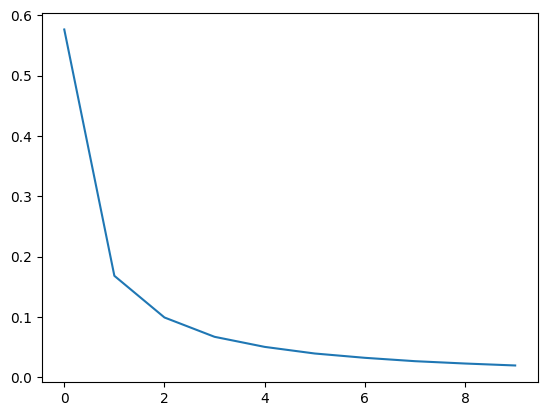

In [8]:
print(loss_data)
plt.plot(loss_data["epoch"], loss_data["loss"])
plt.show()

准确率

In [9]:
net.eval()
yhat = []
epoch = 0
accuracy_sum = 0
for images, labels in testloader:
    images = images.to(device=try_gpu())
    labels = labels.to(device=try_gpu())
    y_predict = net(images)
    y_predict = torch.argmax(y_predict, dim = 1)
    accuracy = torch.eq(labels, y_predict).float().mean()
    accuracy_sum = accuracy_sum + accuracy
    epoch = epoch + 1
print("平均精准度：%f" % (accuracy_sum / epoch))

平均精准度：0.902667
